In [9]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()

In [4]:
def addsecondExposure():
    global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2=[]
    uobs2=[]
    gobs2=[]
    robs2=[]
    iobs2=[]
    zobs2=[]
    yobs2=[]
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [11]:
def averageFlux(observations, Frequency):
    b = [0]*len(observations)
    for seconds in range(0, 15):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/15 for z in b]
    d = [z + z*random.gauss(0, 0.1) for z in c]
    return d

In [43]:
def lombScargle(frequencyRange): # frequency range in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency
    actualperiod = []
    measuredperiod = []
    measuredpower = []
    for frange in range(0, len(frequencyRange)):    
        allobsy=[]
        uobsy=[]
        gobsy=[]
        robsy=[]
        iobsy=[]
        zobsy=[]
        yobsy=[]
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy]
        for z in range(0, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange])

        for z in range(0, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [0.1 * t for t in y[z]]
            frequency, power = LombScargle(date, amplitude).autopower()
            plt.plot(frequency, power)  
            plt.xlabel('frequency')
            plt.ylabel('power')
            plt.show()
            #print(1/frequency)
            #print(power.max())
            maxpos = [i for i, j in enumerate(power) if j == power.max()]
            LSperiod = (1./frequency[maxpos])
            period = 100./(frequencyRange[frange])
            phase = [(day.value % period)/period for day in date]
            plt.plot(phase, amplitude, 'o')
            plt.show()
            print(LSperiod)
            print(frequencyRange[frange])
            print(period)

        actualperiod.append(1/(frequencyRange[frange]*0.01))
        measuredperiod.append(period)
        measuredpower.append(power.max())

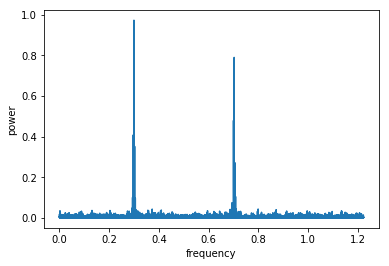

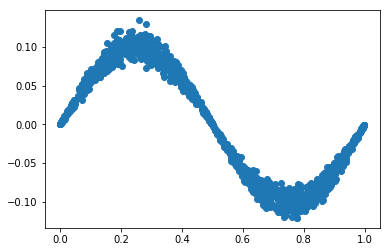

[ 3.33358654] d
30
3.33333333333


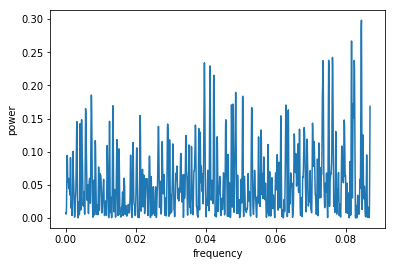

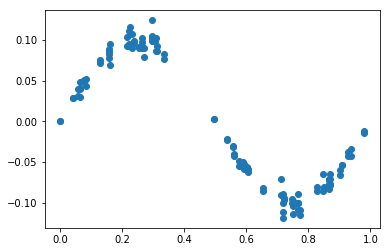

[ 11.83701983] d
30
3.33333333333


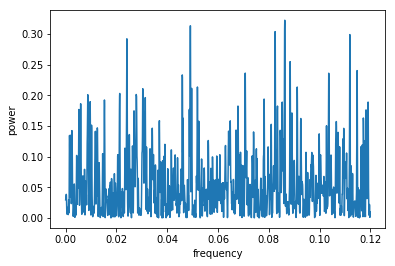

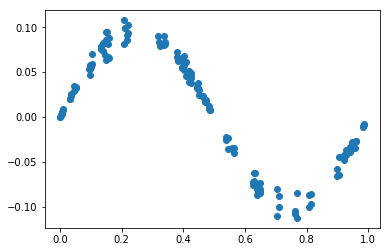

[ 11.58869164] d
30
3.33333333333


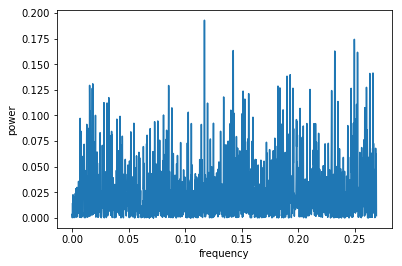

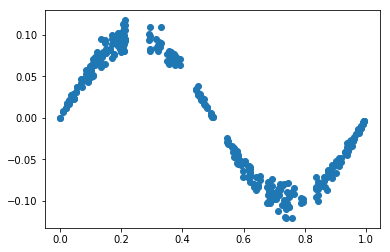

[ 8.54073589] d
30
3.33333333333


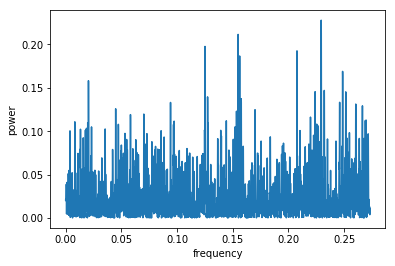

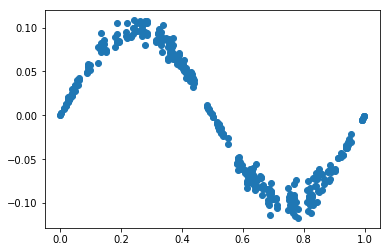

[ 4.35765425] d
30
3.33333333333


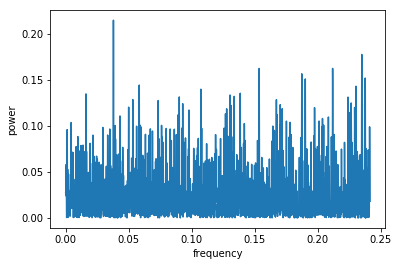

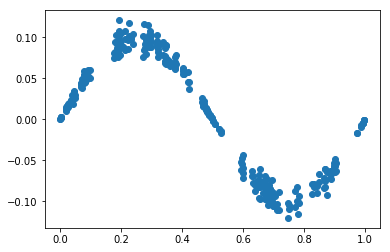

[ 26.35084466] d
30
3.33333333333


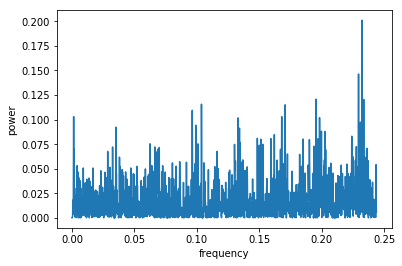

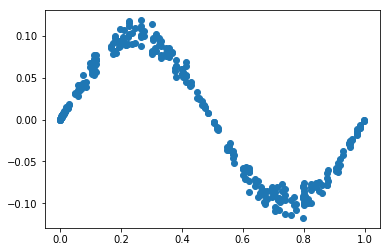

[ 4.30626561] d
30
3.33333333333


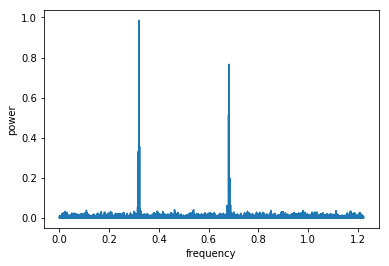

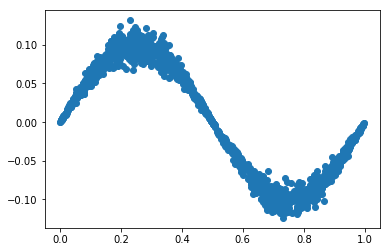

[ 3.12491699] d
32
3.125


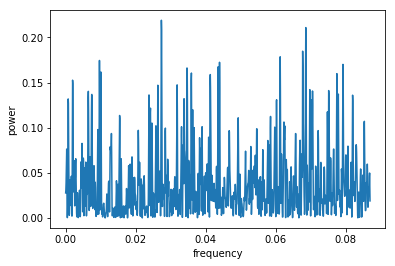

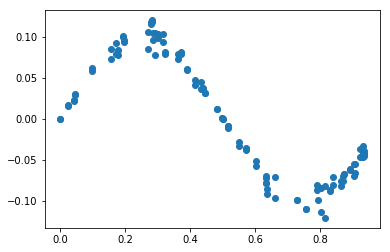

[ 36.54825727] d
32
3.125


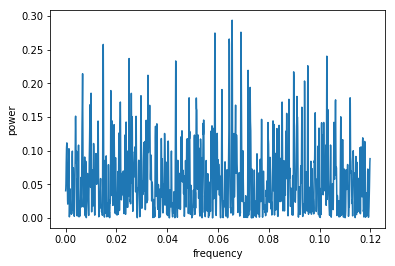

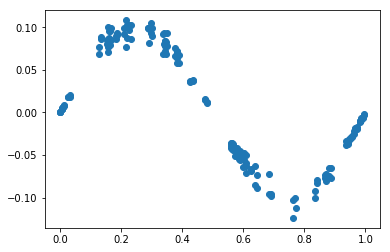

[ 15.24664692] d
32
3.125


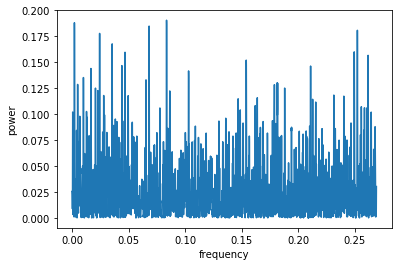

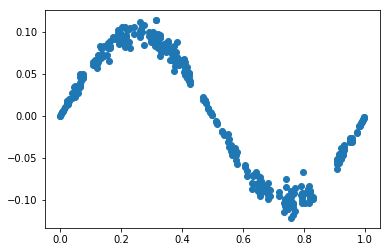

[ 11.96535397] d
32
3.125


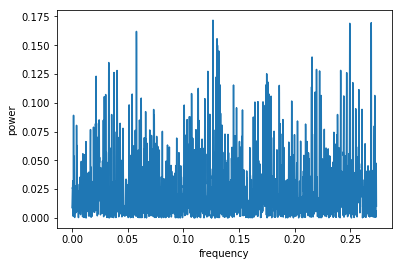

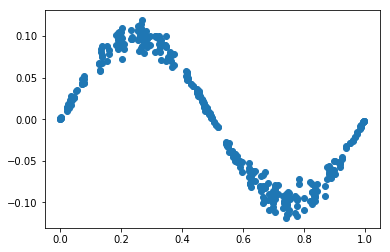

[ 7.90084097] d
32
3.125


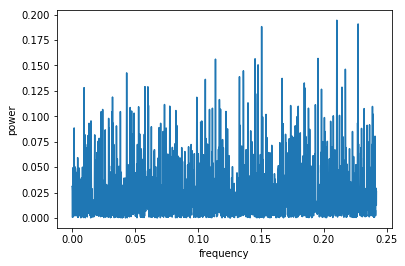

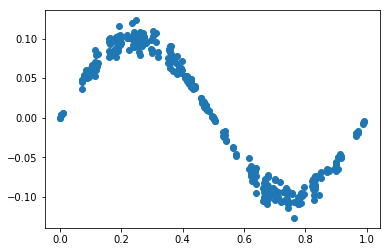

[ 4.75643086] d
32
3.125


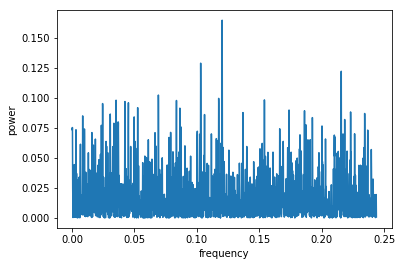

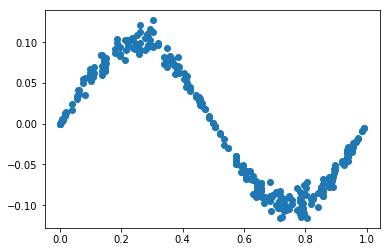

[ 8.31457403] d
32
3.125


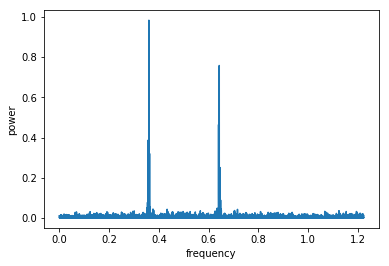

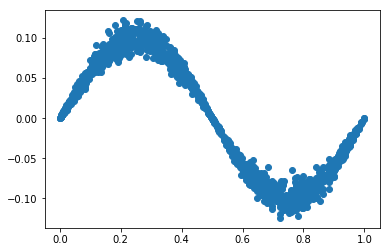

[ 2.77767608] d
36
2.77777777778


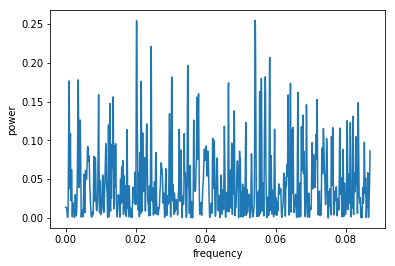

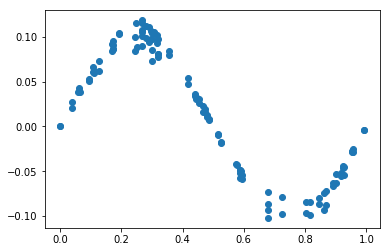

[ 18.46627498] d
36
2.77777777778


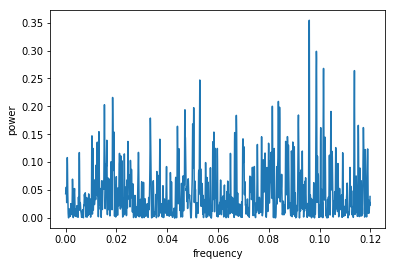

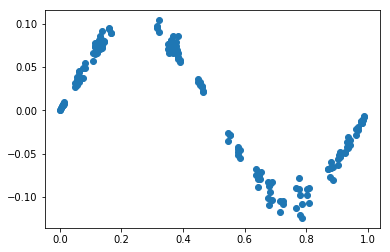

[ 10.42311156] d
36
2.77777777778


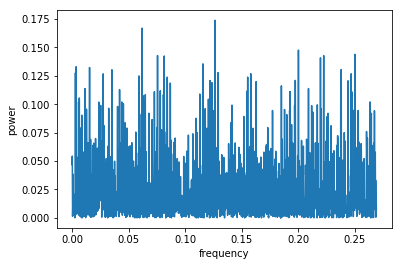

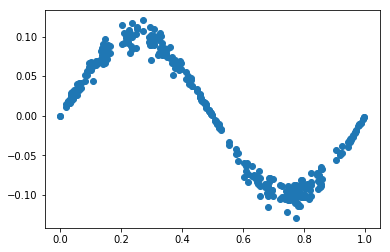

[ 7.90808878] d
36
2.77777777778


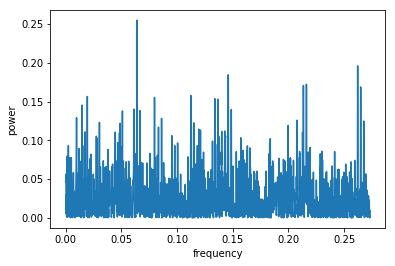

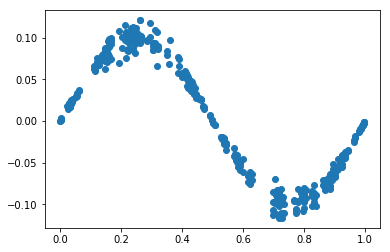

[ 15.63110797] d
36
2.77777777778


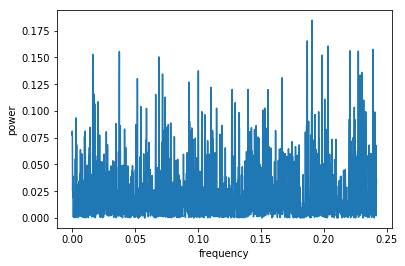

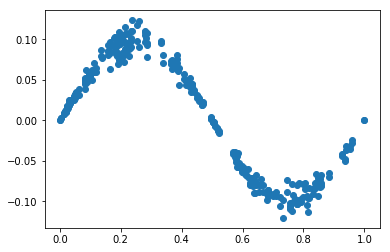

[ 5.24615905] d
36
2.77777777778


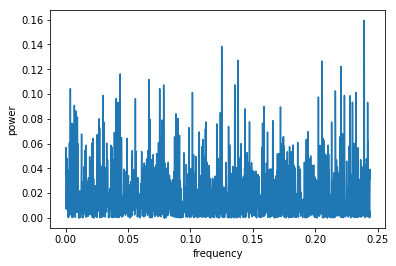

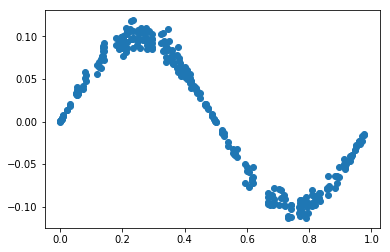

[ 4.18216271] d
36
2.77777777778


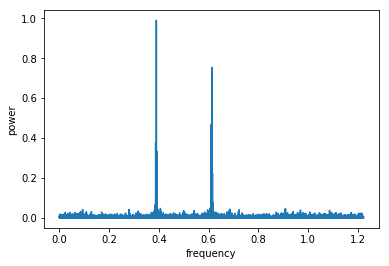

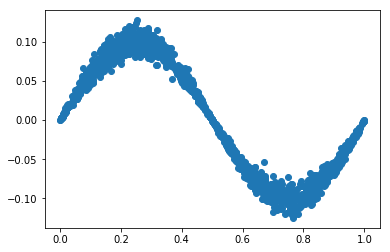

[ 2.56408798] d
39
2.5641025641


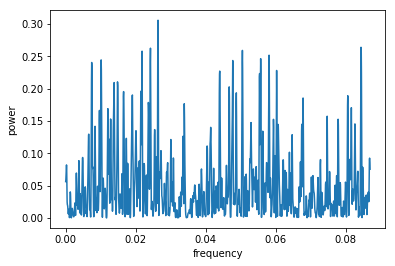

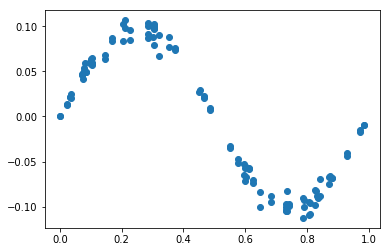

[ 37.87577626] d
39
2.5641025641


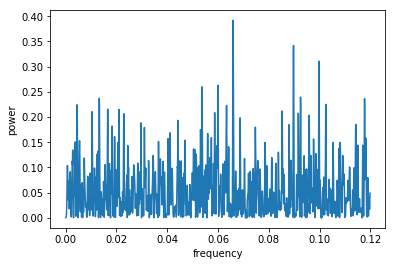

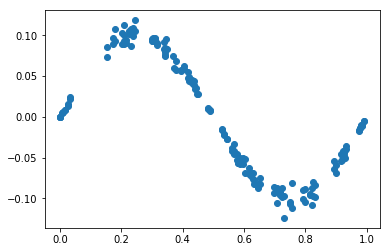

[ 15.16551177] d
39
2.5641025641


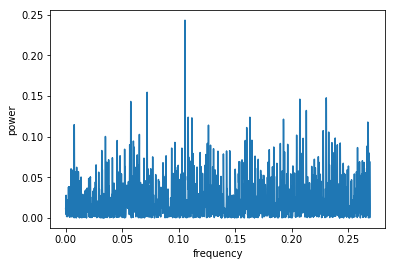

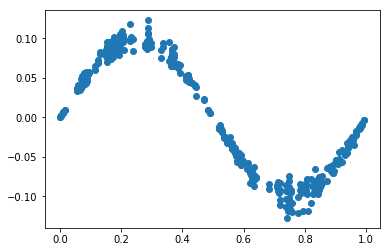

[ 9.47793271] d
39
2.5641025641


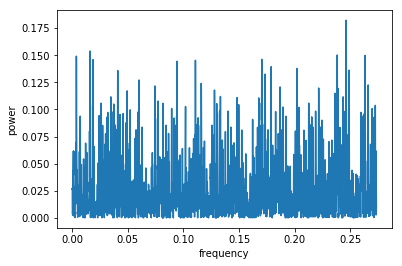

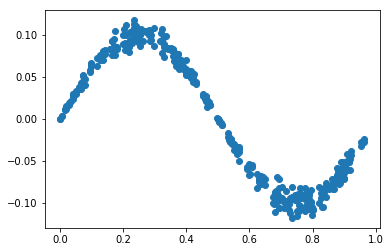

[ 4.06315487] d
39
2.5641025641


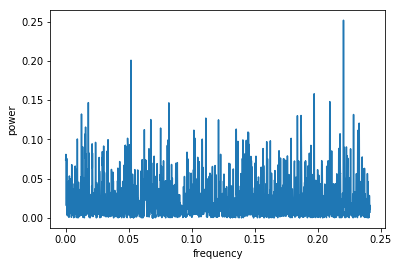

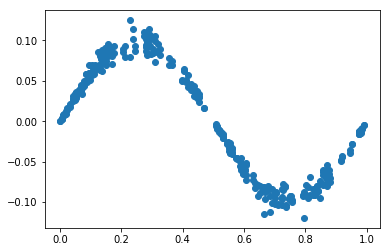

[ 4.53299532] d
39
2.5641025641


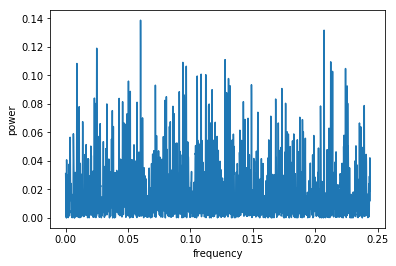

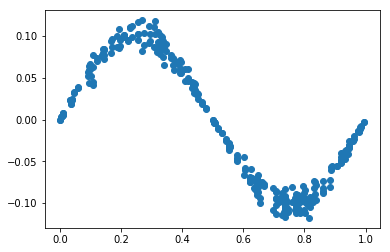

[ 16.66556225] d
39
2.5641025641


In [44]:
findObservations([(630,)])
addsecondExposure()
averageFlux(obs[0], 1)
lombScargle([30,32,36,39])

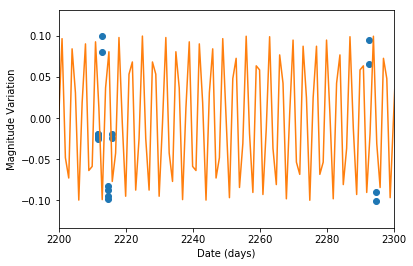

In [29]:
perfex = np.linspace(0, 3500, 3501)
perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
plt.xlim([2200, 2300])
plt.show()

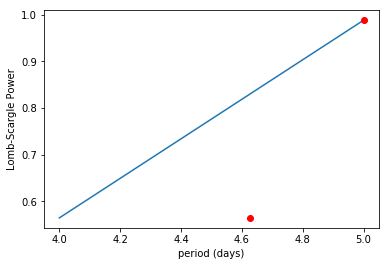

In [34]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()